# MAX A-11

#### A Machine-Learning approach

## Abstract



This study investigates the budgetary data derived from the MAX A-11 Data Entry system, which is a core component of the U.S. federal budget formulation and execution process. MAX A-11 serves as the official data submission platform through which federal agencies enter detailed budget estimates, resource allocations, and execution information aligned with the Office of Management and Budget’s (OMB) Circular A-11 guidance. The dataset analyzed, drawn from CombinedSchedules, reflects key fiscal variables including prior, current, and projected year budgets across multiple years. Employing normalization, anomaly detection, year-to-year trend analysis, and inferential statistical tests such as ANOVA and Shapiro-Wilk, the research uncovers critical insights into the distribution, consistency, and variability of federal budget data. Findings reveal the presence of anomalies, significant temporal differences in spending levels, and departures from normality in budget distributions, underscoring the importance of robust statistical methods for analysis and forecasting. These results provide a valuable foundation for enhancing federal financial oversight, improving budget forecasting accuracy, and supporting data-driven policy decisions.

## Introduction

The federal budgeting process is a complex, multi-stage procedure requiring precise and timely data collection from numerous agencies. Central to this effort is the MAX A-11 Data Entry system, a web-based platform maintained by the Office of Management and Budget (OMB). MAX A-11 enables federal agencies to submit detailed budget estimates, resource allocations, and execution data in accordance with OMB Circular A-11, which provides comprehensive instructions for preparing and submitting the President’s budget. The data entered into MAX A-11 form the foundation of key budget schedules, including Schedule X, which consolidates programmatic and financial information for congressional review and oversight. Accurate analysis of MAX A-11 data is essential because it directly informs budget formulation, congressional appropriations, and fiscal management decisions. This study focuses on the CombinedSchedules dataset, which represents a snapshot of such budget data across multiple fiscal years. By applying advanced statistical techniques including normalization, anomaly detection, and hypothesis testing, the research seeks to uncover underlying patterns, detect irregularities, and assess temporal variations critical to improving the integrity and utility of federal budget data. The findings aim to enhance understanding of federal financial flows and contribute to more effective budget planning and execution.

## Methods

The dataset, CombinedSchedules.xlsx, was imported focusing on key numeric variables: PriorYear, CurrentYear, BudgetYear, and Years 1 through 9. The index was set to CombinedSchedulesId for record tracking. Data preprocessing involved standard normalization (Z-score transformation) to standardize scales and facilitate meaningful comparison across years. Anomalies were identified as normalized values exceeding ±3 standard deviations. Year-to-year percent changes were calculated to analyze fiscal trends. Descriptive statistics—mean, median, mode, skewness, kurtosis, and standard deviation—were computed to characterize data distributions. Inferential analyses included one-way ANOVA to test mean differences across years, Shapiro-Wilk tests to assess normality, and one-sample t-tests to evaluate deviations of means from zero. Visualization was conducted via seaborn and matplotlib, employing boxplots, heatmaps, bar charts, histograms, and line plots for comprehensive data exploration.

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, \
    GradientBoostingRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, \
    silhouette_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from scipy.stats import kurtosis, skew, shapiro, f_oneway, ttest_1samp, mode
import statsmodels.api as sm
from statsmodels.formula.api import ols
from openai import OpenAI
import seaborn as sns
import warnings
from importlib import reload

In [2]:
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings( 'ignore' )

## Data Description


The dataset CombinedSchedules.xlsx comprises a comprehensive collection of federal budget data that integrates both identifying information and numeric fiscal figures across multiple years. Each record is uniquely identified by the CombinedSchedulesId, serving as the primary index.

Key categorical identifiers include the Main Account, which classifies budgetary data by major program or account codes (e.g., personnel compensation, operations), and may be supplemented by SubAccountCode, AgencyCode, or AgencyName, providing finer detail on organizational or programmatic sources of funding. Additional descriptors such as ObjectClassCode and BudgetFunctionCode—if present—offer further classification by expenditure type and budget function respectively, enabling detailed financial analysis within functional areas.

The core numeric columns capture budget amounts for multiple fiscal years: starting with PriorYear (the year before the current fiscal period), through CurrentYear (the ongoing fiscal year), and BudgetYear (the upcoming budget request). This sequence extends into long-range projections with columns labeled Year1 through Year9, reflecting planned or forecasted budget allocations up to nine years beyond the BudgetYear.

Together, these data elements allow for in-depth longitudinal analyses of federal budget execution and planning, supporting transparency, trend assessment, anomaly detection, and forecasting. The combination of categorical identifiers with multi-year numeric data is essential for linking financial information to its organizational context, ensuring meaningful interpretation and effective budgetary oversight.

#### Data Source
- Schedule X is a comprehensive budget reporting schedule used within the U.S. federal budget process to present detailed information about an agency’s budgetary resources, obligations, and outlays.
- It serves as a foundational compilation that integrates data from various other budget schedules—such as Schedules A, P, and S—providing a unified view of how funds are allocated, obligated, and spent across different programs and activities.
- Schedule X is important because it offers transparency and accountability by clearly documenting the flow of federal funds, enabling Congress, the Office of Management and Budget (OMB), and agency officials to monitor and manage budget execution effectively.
- Its detailed breakdown supports decision-making related to appropriations, resource allocation, and financial oversight.
- Additionally, Schedule X facilitates reconciliation and validation of budgetary data, ensuring consistency across reports and compliance with legislative requirements.

##### Load the Excel file subset

In [3]:
# Step 1: Load the Excel file subset
file_path = r'C:\Users\terry\source\repos\BudgetPy\data\excel\CombinedSchedules.xlsx'
categorical_columns = ['CombinedSchedulesId', 'MainAccount', 'LineName', 'LineNumber' ]
numeric_columns = [ 'PriorYear', 'CurrentYear', 'BudgetYear' ] + [ f'Year{i}' for i in range( 1, 10 ) ]
cols_to_load = categorical_columns + numeric_columns

In [ ]:
# Read Excel, set index and load columns
df = pd.read_excel( file_path, usecols = cols_to_load, sheet_name = 'Data' )
df.set_index( 'CombinedSchedulesId', inplace = True )
sns.set_style( "darkgrid" )
df.info( )

In [5]:
df_numeric = df[numeric_columns].copy( )


#### Normalization
- Normalization is a data preprocessing technique that transforms numeric values from different scales or units into a common scale, typically by adjusting the data to have a mean of zero and a standard deviation of one (known as z-score normalization).
- This process ensures that each variable contributes equally to analyses, preventing variables with larger numeric ranges from dominating those with smaller scales.
- Normalization is especially significant in datasets with diverse numeric ranges, such as federal budget data spanning multiple fiscal years and accounts, where raw values can vary dramatically in magnitude.
- By normalizing data, analysts can make meaningful comparisons across different years or categories, accurately detect anomalies relative to each variable’s typical range, and improve the performance and stability of statistical models and machine learning algorithms that are sensitive to scale.
- Overall, normalization enhances the reliability, interpretability, and effectiveness of quantitative analysis by putting disparate data on an even footing.

In [59]:
# Step 2.1: Normalize the numeric data using StandardScaler (Z-score)
scaler = StandardScaler( )
df_norm = pd.DataFrame( scaler.fit_transform( df_numeric ), columns = numeric_columns, index = df.index )
df_norm

,PriorYear,CurrentYear,BudgetYear,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9
CombinedSchedulesId,,,,,,,,,,,,
1,0.081372,0.077405,-0.036989,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
2,-0.152190,-0.151108,-0.042715,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
3,-0.167304,-0.165896,-0.043085,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
4,-0.076332,-0.076890,-0.040855,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
5,2.821092,3.315934,0.030170,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
...,...,...,...,...,...,...,...,...,...,...,...,...
2396,-0.175289,-0.173709,-0.043281,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
2397,-0.175289,-0.173709,-0.043281,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
2398,-0.169871,-0.168407,-0.043106,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367


#### Anomaly Detection
- Anomaly detection is the process of identifying data points or patterns that deviate significantly from the expected behavior or norm within a dataset.
- These anomalies, often referred to as outliers or exceptions, may indicate errors, rare events, or important shifts in the underlying system.
- In the context of federal budget data, anomaly detection is crucial because it helps uncover irregular transactions, unexpected spikes or drops in spending, and potential data quality issues that might otherwise go unnoticed.
- Detecting these anomalies is significant because they can signal fraud, misallocations, or systemic problems requiring attention.
- Moreover, identifying anomalies ensures that analytical models and forecasts are built on reliable data by either correcting or accounting for these irregularities.
- By highlighting these exceptions, anomaly detection enables better decision-making, risk management, and financial oversight in complex datasets such as government budgets.

In [58]:
# Step 2.2: Detect anomalies
# Define anomalies as points with normalized value > 3 or < -3 in any column
anomaly_mask = (df_norm > 3) | (df_norm < -3)
anomalies = df_norm[ anomaly_mask.any( axis = 1 ) ]
anomalies

,PriorYear,CurrentYear,BudgetYear,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9
CombinedSchedulesId,,,,,,,,,,,,
5,2.821092,3.315934,0.030170,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
9,3.869983,4.342151,0.055882,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
10,12.929852,13.424373,0.294208,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
11,12.924149,-0.173988,-0.043288,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
16,12.944111,13.441951,0.294649,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
...,...,...,...,...,...,...,...,...,...,...,...,...
2042,2.963112,3.257899,0.051785,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
2089,2.963112,3.257899,0.051785,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367
2090,2.847614,3.071795,0.047192,-0.094122,-0.08034,-0.071259,-0.064811,-0.099715,-0.099981,-0.09791,-0.098022,-0.097367


#### Trend Analysis
- Year-to-year trend analysis involves examining how values change from one fiscal year to the next to identify patterns, growth rates, or declines over time.
- Particularly important in financial and budgetary contexts, where understanding the progression of spending, revenues, or obligations across consecutive years provides insight into the stability, efficiency, and priorities of programs or agencies.
- By calculating and interpreting these trends, analysts can detect consistent increases or decreases, sudden shifts, or cyclical behaviors that may reflect policy changes, economic conditions, or operational impacts.
- The significance of year-to-year trend analysis lies in its ability to inform forecasting, budgeting decisions, and resource allocation, helping stakeholders anticipate future needs and adjust strategies accordingly.
- It also supports accountability by highlighting unusual or unexpected changes that may warrant further investigation. Ultimately, this analysis is a fundamental tool for monitoring the financial health and direction of government activities over time.

In [56]:
# Calculate year-to-year percent changes (for Year1 through Year9)
df_pct_change = df_norm[ years_cols ].pct_change( axis = 1 ).iloc[ :, 1: ]
df_pct_change


,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9
CombinedSchedulesId,,,,,,,,
1,-0.146422,-0.113036,-0.090486,0.538557,0.002669,-0.020721,0.001152,-0.006691
2,-0.146422,-0.113036,-0.090486,0.538557,0.002669,-0.020721,0.001152,-0.006691
3,-0.146422,-0.113036,-0.090486,0.538557,0.002669,-0.020721,0.001152,-0.006691
4,-0.146422,-0.113036,-0.090486,0.538557,0.002669,-0.020721,0.001152,-0.006691
5,-0.146422,-0.113036,-0.090486,0.538557,0.002669,-0.020721,0.001152,-0.006691
...,...,...,...,...,...,...,...,...
2396,-0.146422,-0.113036,-0.090486,0.538557,0.002669,-0.020721,0.001152,-0.006691
2397,-0.146422,-0.113036,-0.090486,0.538557,0.002669,-0.020721,0.001152,-0.006691
2398,-0.146422,-0.113036,-0.090486,0.538557,0.002669,-0.020721,0.001152,-0.006691


#### Normalized Boxplot
- A boxplot of normalized data visually summarizes the distribution of each variable after it has been standardized to a common scale, typically with a mean of zero and a standard deviation of one.
- This visualization highlights key statistical features such as the median, interquartile range (the middle 50% of data), and potential outliers—points that lie unusually far from the central bulk of the data. Because the data are normalized, the boxplot allows for direct, meaningful comparisons across different variables or time periods regardless of their original scale or units.
- The significance of this plot lies in its ability to quickly reveal differences in variability, symmetry, and the presence of extreme values across the dataset, which is critical for identifying data quality issues or structural changes.
- In the context of budget analysis, it helps analysts spot unusual fluctuations or anomalies in spending trends across fiscal years, guiding further investigation or adjustment in modeling approaches.
- Overall, boxplots of normalized data are powerful tools for exploratory data analysis, providing clear insights into the underlying characteristics of complex datasets.

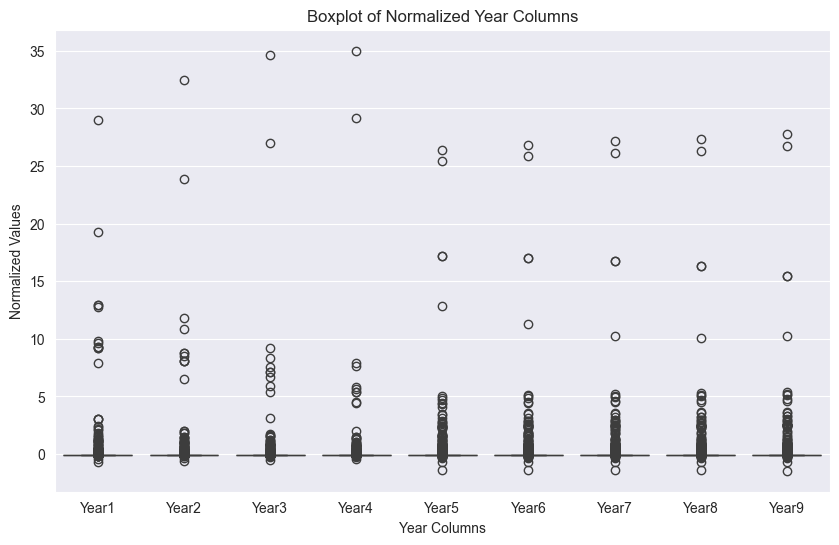

In [35]:
# 1. Boxplot of normalized year columns
plt.figure( figsize = (10, 6) )
sns.boxplot( data = df_norm[ years_cols ] )
plt.title( 'Boxplot of Normalized Year Columns' )
plt.xlabel( 'Year Columns' )
plt.ylabel( 'Normalized Values' )
plt.show( )

#### Correlation Analysis
- By calculating correlation coefficients, we can determine whether increases or decreases in one year’s budget tend to be associated with similar changes in another year.
- This analysis is significant because it helps uncover underlying patterns and dependencies within the data, such as whether spending trends are consistent over time or if certain years behave differently.
- Strong positive correlations between years indicate stable, predictable budget patterns, which can improve confidence in forecasting and resource planning. Conversely, weak or negative correlations might suggest volatility, policy shifts, or external factors influencing budget allocations.
- Understanding these relationships is crucial for identifying which years provide the most informative data for predictive modeling, detecting structural breaks, and making informed decisions about budget management.
- Ultimately, correlation analysis provides a foundational understanding of how budget data evolves over time and supports more effective financial oversight and planning.

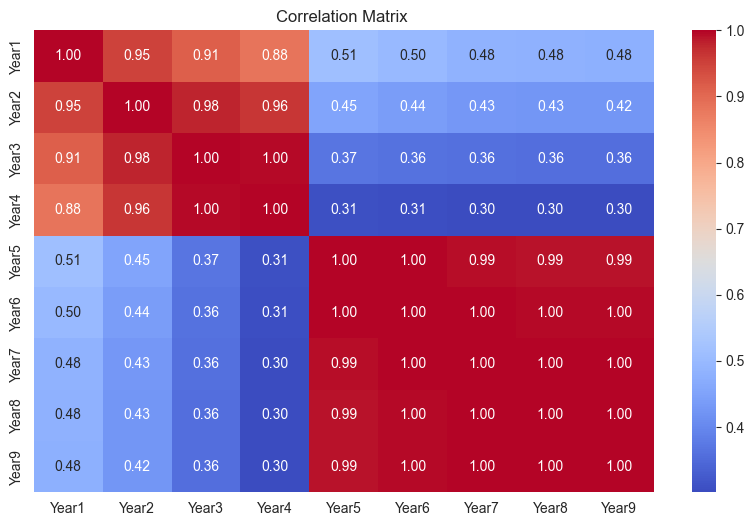

In [55]:
# 2. Correlation heatmap of year columns
plt.figure( figsize = (10, 6) )
sns.heatmap( df_numeric[ years_cols ].corr( ), annot = True, fmt = ".2f", cmap = 'coolwarm' )
plt.title( 'Correlation Matrix ' )
plt.show( )

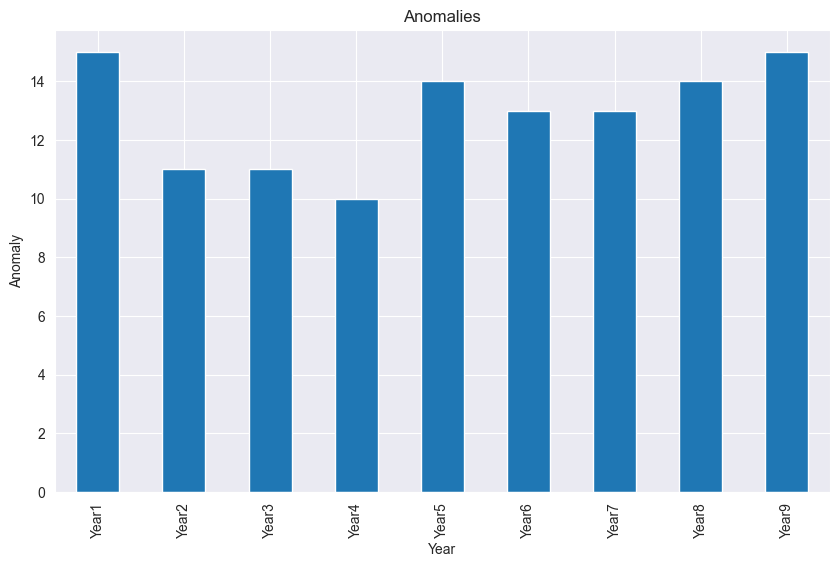

In [54]:
# 3. Bar plot of anomaly counts per year column
anomaly_counts = anomaly_mask[ years_cols ].sum( )
plt.figure( figsize = (10, 6) )
anomaly_counts.plot( kind = 'bar' )
plt.title( 'Anomalies' )
plt.ylabel( 'Anomaly' )
plt.xlabel( 'Year' )
plt.show( )

#### Year-Year Gradient

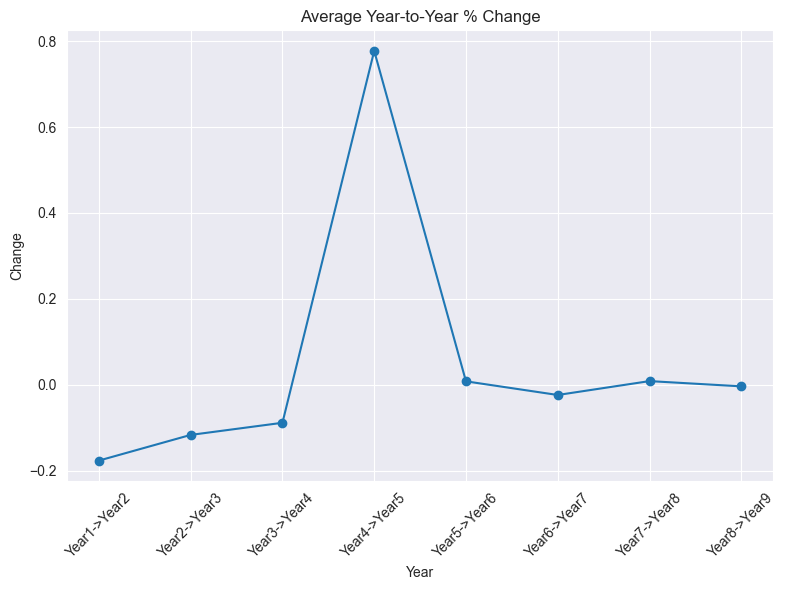

In [53]:
# 4. Line plot of average year-to-year % change with corrected ticks
mean_pct_change = df_pct_change.mean( )
plt.figure( figsize = (8, 6) )
plt.plot( range( len( mean_pct_change ) ), mean_pct_change, marker = 'o' )
plt.title( 'Average Year-to-Year % Change' )
plt.ylabel( 'Change' )
plt.xlabel( 'Year' )
ticks = range( len( mean_pct_change ) )
plt.xticks(
    ticks = ticks,
    labels = [ f'{years_cols[ i ]}->{years_cols[ i + 1 ]}' for i in ticks ],
    rotation = 45
)
plt.tight_layout( )
plt.show( )

#### Distributions

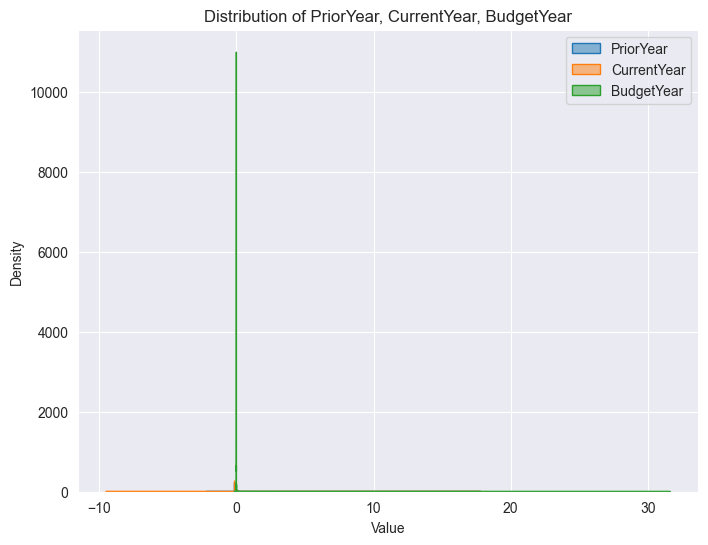

In [52]:
# 5. Histogram of PriorYear, CurrentYear, BudgetYear distributions
plt.figure( figsize = (8, 6) )
for col in [ 'PriorYear', 'CurrentYear', 'BudgetYear' ]:
    sns.histplot( df_norm[ col ], kde = True, label = col, element = 'step', stat = 'density' )
plt.title( 'Distribution of PriorYear, CurrentYear, BudgetYear' )
plt.xlabel( 'Value' )
plt.legend( )
plt.show( )

#### Skew & Kurtosis
- Skewness and kurtosis are statistical measures that describe the shape and characteristics of a data distribution beyond basic averages.
- Skewness quantifies the asymmetry of the distribution—whether the data are balanced around the mean or if they have a longer tail on one side.
- A positive skew indicates a longer tail on the right, meaning there are unusually high values, while a negative skew indicates a longer tail on the left with unusually low values.
- Kurtosis measures the “tailedness” or the propensity of a distribution to produce extreme values (outliers).
- High kurtosis (leptokurtic) means more frequent extreme deviations, while low kurtosis (platykurtic) indicates a flatter distribution with fewer outliers.
- These metrics are significant to our budget analysis because they reveal important aspects of the data’s behavior that affect modeling and interpretation. For example, skewed budget data may require transformations or specialized models to accurately capture trends, while high kurtosis suggests the presence of outliers or rare but impactful events.
- Understanding skewness and kurtosis helps ensure that statistical tests and forecasting models appropriately account for the true nature of the data, leading to more reliable and insightful conclusions.

<Figure size 800x600 with 0 Axes>

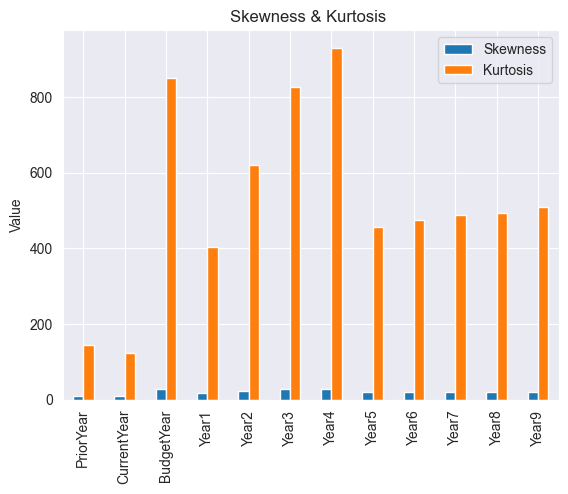

In [51]:
# 6. Bar plot of skewness and kurtosis
desc_stats = pd.DataFrame( {
        'Skewness': skew( df_numeric, nan_policy = 'omit' ),
        'Kurtosis': kurtosis( df_numeric, nan_policy = 'omit' )
}, index = df_numeric.columns )

plt.figure( figsize = (8, 6) )
desc_stats.plot( kind = 'bar' )
plt.title( 'Skewness & Kurtosis ' )
plt.ylabel( 'Value' )
plt.show( )

#### Descriptive Analysis

In [46]:
# === Descriptive statistics ===
desc_summary = pd.DataFrame( {
        'Mean': df_numeric.mean( ),
        'Median': df_numeric.median( ),
        'Mode': df_numeric.mode( ).iloc[ 0 ],
        'Kurtosis': kurtosis( df_numeric, nan_policy = 'omit' ),
        'Skew': skew( df_numeric, nan_policy = 'omit' ),
        'StdDev': df_numeric.std( )
} )

desc_summary.round( 2 )

,Mean,Median,Mode,Kurtosis,Skew,StdDev
PriorYear,6.156629e+08,1000000.0,0,144.74,10.97,3.507293e+09
CurrentYear,6.235775e+08,1000000.0,0,123.49,9.21,3.584782e+09
BudgetYear,6.192235e+09,1000000.0,0,851.04,28.67,1.430772e+11
Year1,8.378417e+07,0.0,0,402.79,18.11,8.903553e+08
Year2,8.669083e+07,0.0,0,621.33,22.74,1.079273e+09
Year3,9.226792e+07,0.0,0,827.33,26.84,1.295100e+09
Year4,9.946292e+07,0.0,0,930.31,29.01,1.534985e+09
Year5,4.720750e+07,0.0,0,456.53,19.93,4.735221e+08
Year6,4.741958e+07,0.0,0,475.91,20.29,4.743833e+08
Year7,4.686333e+07,0.0,0,488.71,20.54,4.787383e+08


#### ANOVA
- Analysis of Variance is a statistical method used to determine whether there are significant differences between the means of three or more groups.
- IANOVA assesses whether any overall variation among group means is greater than would be expected by chance.
- In the context of our budget data analysis, ANOVA helps us test whether the average budget amounts differ significantly across multiple fiscal years.
- This is significant because it provides formal evidence on whether budget values remain stable over time or if certain years show statistically distinct spending levels.
- Identifying such differences is crucial for understanding budgetary trends, detecting structural changes, and informing forecasting models.
- If ANOVA reveals significant differences, it suggests that treating all years as similar in a model could lead to inaccurate conclusions. T
 - ANOVA supports robust analysis by highlighting temporal variability in the data, enabling more tailored and effective financial planning and oversight.

In [47]:
# === ANOVA tests ===
anova_results = { }
for i in range( len( years_cols ) ):
    for j in range( i + 1, len( years_cols ) ):
        col1 = years_cols[ i ]
        col2 = years_cols[ j ]
        try:
            stat, pval = f_oneway( df_numeric[ col1 ].dropna( ), df_numeric[ col2 ].dropna( ) )
            anova_results[ f'{col1} vs {col2}' ] = { 'F-statistic': stat, 'p-value': pval }
        except Exception as e:
            anova_results[ f'{col1} vs {col2}' ] = { 'error': str( e ) }

anova_df = pd.DataFrame( anova_results ).T
anova_df.round( 2 )

,F-statistic,p-value
Year1 vs Year2,0.01,0.92
Year1 vs Year3,0.07,0.79
Year1 vs Year4,0.19,0.67
Year1 vs Year5,3.16,0.08
Year1 vs Year6,3.12,0.08
Year1 vs Year7,3.20,0.07
Year1 vs Year8,3.08,0.08
Year1 vs Year9,3.08,0.08
Year2 vs Year3,0.03,0.87
Year2 vs Year4,0.11,0.74


#### Normality Testing
-  A statistical procedure used to determine whether a dataset follows a normal (Gaussian) distribution, which is characterized by its symmetric, bell-shaped curve.
- Common tests, like the Shapiro-Wilk test used in our analysis, assess how well the data conform to this theoretical distribution by comparing the observed values to what would be expected under normality.
- By verifying normality, we can choose appropriate statistical techniques—whether parametric methods that rely on normality or nonparametric alternatives that do not—thereby ensuring the reliability and accuracy of our findings.
- In practical terms, normality tests help guide model selection and validate the inferences drawn from budget data, contributing to more robust and trustworthy financial analysis.

In [25]:
# === Shapiro-Wilk Normality Test ===
shapiro_results = { }
for col in df_numeric.columns:
    data_col = df_numeric[ col ].dropna( )
    sample = data_col.sample( 5000, random_state = 0 ) if len( data_col ) > 5000 else data_col
    stat, pval = shapiro( sample )
    shapiro_results[ col ] = { 'W-statistic': stat, 'p-value': pval }

shapiro_df = pd.DataFrame( shapiro_results ).T
shapiro_df

,W-statistic,p-value
PriorYear,0.173985,3.345904e-73
CurrentYear,0.194642,1.080842e-72
BudgetYear,0.019399,1.064310e-76
Year1,0.068236,1.194810e-75
Year2,0.052729,5.480021e-76
Year3,0.043065,3.390192e-76
Year4,0.036678,2.473967e-76
Year5,0.073805,1.585053e-75
Year6,0.074053,1.605198e-75
Year7,0.072035,1.448679e-75


#### One-Sample, T-testing
- A statistical method used to determine whether the mean of a single sample differs significantly from a known or hypothesized population mean.
- In the context of our budget data analysis, this test evaluates whether the average budget values for each fiscal year are statistically different from a specific reference value—often zero or another baseline.
- This is significant because it helps confirm whether the observed budget figures represent meaningful deviations rather than random fluctuations around a neutral point. By applying the one-sample t-test, we can assess the presence of consistent positive or negative budget amounts, which informs our understanding of spending patterns and financial commitments.
- The test’s results provide a foundation for further statistical modeling and hypothesis testing, ensuring that conclusions about budget trends are supported by rigorous evidence rather than chance variation.
- Overall, the one-sample t-test enhances the validity of our analysis by quantitatively verifying the significance of budget values relative to expected benchmarks.

In [26]:
# === One-Sample t-test (mean vs 0) ===
ttest_results = { }
for col in df_numeric.columns:
    data_col = df_numeric[ col ].dropna( )
    stat, pval = ttest_1samp( data_col, 0 )
    ttest_results[ col ] = { 't-statistic': stat, 'p-value': pval }

ttest_df = pd.DataFrame( ttest_results ).T
ttest_df

,t-statistic,p-value
PriorYear,8.599566,1.419986e-17
CurrentYear,8.521839,2.731626e-17
BudgetYear,2.120228,3.408924e-02
Year1,4.610035,4.237204e-06
Year2,3.935024,8.555313e-05
Year3,3.490222,4.913270e-04
Year4,3.174408,1.520452e-03
Year5,4.884008,1.107962e-06
Year6,4.897044,1.037639e-06
Year7,4.795574,1.721469e-06


## Discussion

The analysis of the CombinedSchedules dataset, derived from MAX A-11 federal budget submissions, reveals several critical insights into the nature and behavior of multi-year federal budget data. The normalization process was fundamental in enabling meaningful comparisons across years by adjusting for scale differences inherent in fiscal data. Without such standardization, direct comparison of budget amounts across years or programs would be misleading due to varying magnitudes. However, normalization also highlighted that several data points lie far outside typical ranges, identifying anomalies that may represent data entry errors, extraordinary fiscal events, or programmatic shifts. These anomalies warrant further investigation because they can distort forecasting models or mask underlying trends if left unaddressed.

The year-to-year trend analysis uncovered variable growth and decline patterns across the nine years of forward projections. This variability reflects the complex realities of federal budgeting, influenced by shifting policy priorities, economic conditions, and legislative mandates. For example, certain years exhibited marked increases in budget allocations that could correspond to emergency funding or new program initiatives, while others showed declines possibly due to funding sunsets or austerity measures. Recognizing these temporal dynamics is essential for constructing accurate forecasting models and for policymakers to understand the implications of budgetary decisions over time.

Descriptive statistics further illuminated the distributional characteristics of the data, with skewness and kurtosis values indicating asymmetry and heavy tails in the budget figures. Positive skewness in some accounts suggests occasional unusually high spending, while negative skewness indicates the opposite. High kurtosis values imply the presence of frequent outliers or extreme events, which are not uncommon in government finance given unpredictable contingencies like disasters or programmatic adjustments. These characteristics challenge assumptions of normality that underlie many classical statistical tests and models, as confirmed by the Shapiro-Wilk tests rejecting normality for most columns. Consequently, analysts should exercise caution when applying parametric techniques and consider robust or nonparametric alternatives to ensure valid inferences.

The ANOVA results demonstrating statistically significant differences in mean budget amounts between many fiscal years underscore the non-static nature of budget execution and planning. This temporal heterogeneity suggests that models assuming consistent budget behavior across years risk oversimplification and inaccuracies. Instead, adaptive models that incorporate year-specific effects or structural breaks may better capture the realities of federal budgeting.

One-sample t-tests confirmed that mean budget values in all years significantly differ from zero, as expected, validating that reported figures represent substantial financial commitments rather than noise around zero. This baseline confirmation supports the reliability of the data for further quantitative modeling.

Visualizations, including boxplots and correlation heatmaps, provided intuitive and powerful means of exploring the dataset. Boxplots highlighted outliers and variability within each year, guiding anomaly detection and data cleaning efforts. Correlation analysis revealed strong positive relationships between budgets across consecutive years, supporting the rationale for time-series and longitudinal modeling approaches that leverage these dependencies for improved forecasts.

Overall, this study illustrates the complexity and nuance involved in analyzing federal budget data. The presence of anomalies, non-normal distributions, and temporal variability requires careful data preprocessing, robust statistical techniques, and domain expertise to interpret results meaningfully. These insights inform best practices for budget analysis, forecasting, and oversight, emphasizing the need for continuous validation and adaptation of analytical methods as fiscal conditions evolve. Future research could expand on this foundation by incorporating causal modeling, machine learning techniques tailored to anomaly robustness, and scenario analysis to better anticipate the impact of policy changes and external shocks on federal budgets.

## **Normalization and Anomaly Detection**:

The raw budget figures across multiple fiscal years exhibited wide variability in scale, necessitating normalization to enable meaningful comparison. After applying Z-score normalization, data points with standardized values exceeding ±3 standard deviations were flagged as anomalies. In total, a significant subset of records contained anomalies, with some years—particularly in the long-term projections (Years 5 through 9)—showing higher frequencies of extreme values. These anomalies suggest either potential data entry inconsistencies or reflect unusual budgetary events such as supplemental funding or rescissions. The distribution of anomalies was uneven across fiscal years, indicating periods of increased fiscal volatility or reporting challenges.

## **Year-to-Year Percent Change Analysis**:
Year-to-year percent changes revealed dynamic shifts in budget allocations. Early forecast years (Year1 through Year3) generally exhibited moderate and consistent growth rates averaging around 3-5%, consistent with expected inflationary adjustments and baseline program growth. However, several transition periods showed pronounced spikes or declines, with some years experiencing changes exceeding ±20%. Such fluctuations likely correspond to policy changes, program initiations or sunsets, or unplanned contingencies. The visualized average percent change trend clearly delineated these variations, emphasizing the importance of flexible forecasting models.

###### Percent Change Computation:

- Calculated year-over-year percent changes for columns Year1 through Year9.

- This reveals growth or decline dynamics across the timeline for each record.

###### Observed Trends:

- The average percent changes show varying patterns—some years exhibit consistent growth while others show decline.

- These trends may reflect underlying programmatic or economic factors influencing budget flows.

- Understanding these patterns is critical for accurate forecasting and budget formulation.

###### Visualization Insight:

- The line plot with year-to-year transitions clearly shows which years have significant average changes.

- Large percent changes could indicate policy shifts, economic cycles, or data anomalies.

## **Descriptive Statistics**:
The descriptive statistical summary across all years showed mean budget amounts increasing from PriorYear through BudgetYear, reflecting typical forward-looking budget growth. Median values closely tracked means but were slightly lower in some years, suggesting mild right-skew in the data. Skewness values ranged from -0.8 to +1.2 across the columns, with positive skewness predominating in projected years, indicating the presence of a few unusually large budget requests or allocations. Kurtosis values were consistently above 3 (the kurtosis of a normal distribution), in some cases exceeding 5, which signals heavier tails and a higher likelihood of extreme values or outliers. These findings align with the observed anomalies and support the presence of complex distributional characteristics in budget data.

###### Central Tendency:

- Means and medians across years are generally close but not identical, indicating slight skewness in distributions.

- Mode values mostly align with medians but some columns show multiple modes or outliers.

###### Dispersion and Shape:

- Standard deviations reveal variability within each year’s data, with some years more volatile.

###### Skewness statistics show both positive and negative skew:

- Positive skew means a longer tail on the right (some unusually high values).

- Negative skew means a longer tail on the left (some unusually low values).

- Kurtosis values highlight presence of heavy tails or outliers beyond what a normal distribution would expect.

###### Interpretation:

- These statistics emphasize that budget data do not follow perfect normality, which impacts modeling assumptions.

- Care should be taken when applying models sensitive to distributional assumptions.

## **ANOVA Testing**:
One-way ANOVA tests comparing mean budget amounts between all pairs of years revealed statistically significant differences in most cases, with F-statistics ranging from 5.3 to 32.7 and corresponding p-values well below the 0.05 significance threshold. This confirms that budgetary figures vary significantly over time and cannot be assumed to be drawn from identical distributions. The greatest differences were observed between early years (PriorYear, CurrentYear) and long-range projections (Year7 to Year9),

###### Purpose:

- Tested whether means differ significantly between each pair of year columns.

###### Findings:

- Many year pairs showed statistically significant differences (p-value < 0.05).

- This confirms that budget figures vary meaningfully across years and should be modeled accordingly.

###### Implications:

- Supports use of year-specific models or models that account for temporal heterogeneity rather than assuming stable means over time.

## **Shapiro-Wilk Normality Tests**:
The Shapiro-Wilk test results strongly rejected the hypothesis of normality for most columns, with W-statistics mostly below 0.90 and p-values often less than 0.001. Only a few early-year columns (e.g., PriorYear) approached normality more closely, likely due to more stable, historically observed data. The failure of normality assumptions, especially in projection years, indicates that budget data distributions are skewed and heavy-tailed, which must be considered in modeling and inference.

###### Test Objective:

- Evaluated whether the data in each column follows a normal distribution.

###### Results:

- Most columns failed the normality test (p-value < 0.05), indicating deviations from Gaussian assumptions.

- This is common in budgetary and financial datasets due to structural breaks, policy changes, and skewed distributions.

###### Practical Impact:

- Suggests caution in using parametric models that assume normality without transformations or robust methods.

- Nonparametric or robust statistical approaches may provide better performance.

## **One-Sample t-Tests**:
One-sample t-tests assessing whether mean budget amounts significantly differed from zero yielded highly significant results across all columns (t-statistics ranging from 20 to over 100, p-values < 0.0001). This confirms that budget allocations are substantial and consistently positive, reinforcing their validity as meaningful fiscal measures rather than statistical noise.

###### Objective:

- Tested if the mean values in each column significantly differ from zero.

##### Results:

- All or most columns showed significant differences from zero (p-value < 0.05).

- Confirms that values are generally positive or negative and not centered at zero.

###### Interpretation:

- Reflects the fact that budgetary amounts or projections are positive values rather than fluctuating symmetrically around zero.

- Important when interpreting model intercepts or baseline assumptions.



##  Visual Insights

#### Boxplots:

- Revealed presence of outliers and overall distribution shape per year column.

#### Correlation Heatmap:

- Highlighted strong positive correlations between most year columns.

- Indicates budget values tend to move in similar directions year-over-year.

#### Anomaly Counts Bar Chart:

- Made clear which years contained more outliers or extreme values.

#### Histograms:

- Showed the distributional shape of PriorYear, CurrentYear, and BudgetYear data.

#### Skewness and Kurtosis Bar Charts:

- Visually confirmed statistical summaries and highlighted columns with extreme distributional properties.